# Yelp Reviews EDA and Text Mining
This notebook is for Review EDA and feature extraction from reviews. Considering the large number of reviews from 2000 restaurants, we did sampling to get more than 60k reviews from the restaurants. The Wordcloud and LDA model were created, and then TF-IDF was used to extract features. Here we tried 2 types of features. The first one is using principal components based on 1000 keywords tf-idfs, while the second one contains features from 100 key words without PCA.

In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation, strip_numeric,strip_short
nltk.download('wordnet')
np.random.seed(2018)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dt = pd.read_csv("filtered_reviews_rs.csv")

In [4]:
print(dt.shape)
print(dt["business_id"].describe())
dt.head()

(292144, 9)
count                     292144
unique                      2013
top       K7lWdNUhCbcnEvI0NhGewg
freq                        6887
Name: business_id, dtype: object


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,f0B9-r14-bLudyu5S7aLhw,SvMGr_Oih7ivtzmnCL-Tmg,ujHiaprwCQ5ewziu0Vi9rw,1.0,1,0,0,We had dinner at the Bellagio Buffet last nigh...,2013-12-07 00:14:06
1,E4LqIZ7DJd_R4ZHSNKx4RQ,DoRCeCcJbrsM2BiAKj3trA,SU56w479vUfFHsvmvQIf7A,4.0,7,5,6,So good! They didn't make it to 5 stars due to...,2016-07-25 03:55:20
2,QSe9EqmiImbguDVIraX_rg,II8eB5mYk200GW-m-wpsug,z9aXGRH8xtqpNDFE5_I3KA,4.0,0,0,0,received a mailer and thought okay let's go. ...,2015-06-21 00:56:28
3,EedJ77WTwkytYhAR-PVMKQ,piYjHlLZQCtg9Q1QT0Lvbw,gOOfBSBZlffCkQ7dr7cpdw,5.0,0,0,0,Five stars! I highly recommend this place if y...,2018-04-27 18:59:14
4,w1I8U4cJ4QGaXA98ImNrbA,rJNdeta-dYO2YcJ3u5JxnA,faPVqws-x-5k2CQKDNtHxw,5.0,0,0,0,"Service was amazing, Christina was extremely t...",2018-08-04 20:22:15


In [3]:
count_table = dt["business_id"].value_counts()
len_text = [len(text.split()) for text in dt["text"]]
pd.DataFrame(len_text).describe()

,0
count,292144.000000
mean,107.001318
std,101.992747
min,1.000000
25%,41.000000
50%,74.000000
75%,137.000000
max,1010.000000


In [4]:
###get samples from reviews
frames = []
size = 50
for id in dt['business_id'].unique():
    ntext = count_table[id]
    if ntext<=size:
        frames.append(dt[dt['business_id']==id].iloc[:,[2,7]])
    else:
        index = np.random.choice(ntext-1,size = size,replace = False)
        frames.append(dt[dt['business_id']==id].iloc[index,[2,7]])
dt_s = pd.concat(frames)
dt_s.shape
###more than 60k reviews remained after sampling

(64229, 2)

In [ ]:
#### This chunk reeeeally takes time!!!! #####
#language detecting
from langdetect import detect
language_list = []
c = 0
for text in dt_s["text"]:
    try:
        language_list.append(detect(text))
    except:
        language_list.append("unknown")
        print(c)
    c+=1
len(dt_s['text']) - language_list.count('en')

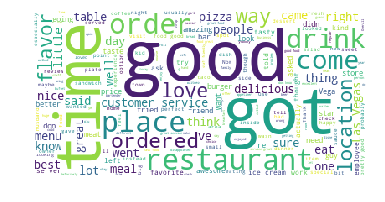

In [5]:
#define a function get_wordcloud to generate wordcloud given a dataset
def get_wordcloud(data):
    Words = [strip_punctuation(strip_numeric(strip_short(remove_stopwords(word)))) for word in data]
    if "got" in Words:
        Words.remove("got")
    Text = ''.join(Words)
    Text.lower()
    plot = plt.imshow(WordCloud(background_color = "white").generate(Text))
    plt.axis('off')
    plt.rcParams['figure.figsize'] = (10,10)
    plt.show()
    return plot
plot = get_wordcloud(dt_s['text'])

In [9]:
###Create preprocessing function consisting of the stemmer, the stopword remover and the lemmatizer.
stemmer = nltk.SnowballStemmer('english')
stopwords = set(pd.read_table("twitter-stopwords.txt",",",header=None).transpose()[0])
print(len(stopwords))
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = list(map(preprocess,dt_s['text']))

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


1411


In [65]:
#prepare corpus
corpus=[preprocess(tag) for tag in dt_s['text']]
dictionary = gensim.corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below=2, no_above=0.99)
corpus = [dictionary.doc2bow(preprocess(tag)) for tag in dt_s['text']]

In [67]:
#lda model
lda_model = gensim.models.LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         random_state=100, 
                         num_topics=10,
                         passes=5,
                         chunksize=10000,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
lda_model.print_topics(-1)

[(0,
  '0.026*"food" + 0.025*"place" + 0.021*"great" + 0.020*"good" + 0.014*"servic" + 0.013*"love" + 0.011*"like" + 0.011*"friend" + 0.010*"come" + 0.010*"time"'),
 (1,
  '0.018*"good" + 0.016*"order" + 0.014*"chicken" + 0.014*"food" + 0.011*"like" + 0.011*"fri" + 0.011*"come" + 0.009*"place" + 0.009*"sauc" + 0.008*"salad"'),
 (2,
  '0.039*"doughnut" + 0.015*"macaron" + 0.014*"creme" + 0.011*"float" + 0.007*"brian" + 0.007*"brûlée" + 0.006*"bobbi" + 0.006*"pink" + 0.006*"teavana" + 0.006*"snooti"'),
 (3,
  '0.099*"pizza" + 0.044*"order" + 0.017*"deliveri" + 0.015*"wing" + 0.015*"place" + 0.014*"time" + 0.012*"good" + 0.011*"chees" + 0.010*"crust" + 0.009*"like"'),
 (4,
  '0.032*"taco" + 0.028*"food" + 0.015*"good" + 0.014*"burrito" + 0.013*"like" + 0.012*"locat" + 0.011*"place" + 0.011*"mexican" + 0.010*"meat" + 0.010*"fresh"'),
 (5,
  '0.071*"water" + 0.021*"great" + 0.016*"latt" + 0.015*"coffe" + 0.015*"drink" + 0.012*"gallon" + 0.011*"peruvian" + 0.010*"servic" + 0.010*"chai" + 0.0

In [10]:
dt_txtarr = pd.DataFrame({"business_id": dt_s["business_id"],"text":[' '.join(arr) for arr in processed_docs]})

In [86]:
#dt_txtarr.to_csv(folder + "preprocessed_reviews.csv")

In [11]:
#Extract tf-idf from preprocessed reviews
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 1000)     #Assign the number of keywords that we want to keep (sorting by their frequencies)
X = vectorizer.fit_transform(dt_txtarr["text"])
#print(vectorizer.get_feature_names())
X.shape

(64229, 1000)

In [14]:
dt_ss = dt_s.reset_index(drop = True)
tfidf_bus = pd.concat([pd.DataFrame(X.toarray()),dt_ss["business_id"]],axis =1).groupby('business_id').mean()
tfidf_bus.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
business_id,,,,,,,,,,,,,,,,,,,,,
-153AjTW5luZPK4omEujWA,0.000000,0.041961,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.181956,0.041763,0.000000,0.000000
-1m9o3vGRA8IBPNvNqKLmA,0.000000,0.026510,0.0,0.018317,0.001485,0.0,0.001515,0.000000,0.006587,0.000000,...,0.035339,0.004384,0.000000,0.0,0.001403,0.000000,0.004316,0.027715,0.000000,0.000000
-46pFijv3f2jZH-_Ze6CQA,0.016922,0.036776,0.0,0.014198,0.000000,0.0,0.000000,0.012692,0.008216,0.000000,...,0.025373,0.003501,0.000000,0.0,0.009644,0.000000,0.000000,0.037420,0.031180,0.000000
-8ZiMXZReeTD3kwEvS0Lww,0.000000,0.020672,0.0,0.012462,0.000000,0.0,0.000000,0.000000,0.001407,0.003491,...,0.009861,0.000000,0.014352,0.0,0.001981,0.000000,0.011705,0.015520,0.003652,0.000000
-9YyInW1wapzdNZrhQJ9dg,0.000000,0.033224,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.008260,0.000000,...,0.042137,0.011063,0.000000,0.0,0.000000,0.008195,0.000000,0.015697,0.004369,0.005171


In [18]:
#TFIDF, only keep 100 words without PCA
vectorizer_word = TfidfVectorizer(max_features = 100)
X_word = vectorizer_word.fit_transform(dt_txtarr["text"])
df_word = pd.DataFrame(X_word.toarray())
print(vectorizer_word.get_feature_names())
df_word.head()
df_word.columns = vectorizer_word.get_feature_names()
word_bus = pd.concat([df_word,dt_ss["business_id"]],axis =1).groupby('business_id').mean()
word_bus.to_csv(folder+"reviews_tfidf_words.csv")

['about', 'after', 'again', 'also', 'alway', 'amaz', 'anoth', 'around', 'be', 'becaus', 'befor', 'best', 'better', 'burger', 'busi', 'chees', 'clean', 'come', 'cook', 'could', 'definit', 'delici', 'dish', 'do', 'down', 'drink', 'drive', 'enjoy', 'even', 'ever', 'everi', 'everyth', 'experi', 'first', 'flavor', 'fresh', 'friend', 'from', 'go', 'have', 'help', 'here', 'know', 'leav', 'littl', 'long', 'manag', 'meal', 'meat', 'more', 'most', 'much', 'need', 'never', 'next', 'other', 'over', 'perfect', 'pizza', 'realli', 'restaur', 'salad', 'sandwich', 'sauc', 'say', 'server', 'sinc', 'some', 'someth', 'staff', 'star', 'still', 'store', 'super', 'sure', 'tabl', 'taco', 'tast', 'than', 'that', 'their', 'them', 'then', 'there', 'they', 'this', 'time', 'tri', 'vega', 'veri', 'walk', 'well', 'what', 'when', 'which', 'while', 'will', 'with', 'would', 'your']


In [55]:
#PCA on 1000 words
from sklearn.decomposition import PCA
pca = PCA()
pc = pca.fit_transform(tfidf_bus)
pd.DataFrame(pc).head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.005318,0.001360,-0.022182,0.028369,-0.003182,0.032384,-0.038534,0.012776,-0.002848,0.005570,...,0.000594,-0.003061,0.001469,0.002486,0.001481,0.001078,0.001125,-0.000919,-0.000245,-0.000339
1,-0.020263,-0.087959,-0.065596,0.008555,-0.010898,0.018884,-0.028855,0.005687,0.064071,0.023381,...,0.001294,-0.001143,0.001850,0.000398,0.000262,0.000536,0.001216,-0.001918,-0.000677,-0.002633
2,-0.027137,-0.039379,-0.046204,0.012708,-0.058207,0.010814,0.018686,0.010811,0.060485,0.015388,...,0.001192,0.001425,-0.001369,-0.003887,-0.000005,-0.001101,-0.000488,-0.002407,0.001364,-0.002385
3,-0.020544,0.000278,-0.007742,0.025690,0.058327,-0.031107,0.013682,-0.042927,-0.002670,0.060895,...,0.000903,-0.000503,-0.002536,-0.000277,0.001296,0.000945,0.001404,-0.001175,0.000244,0.002437
4,-0.007909,-0.022908,-0.040531,-0.010875,-0.039024,-0.013501,0.017099,0.026332,0.019700,0.002203,...,0.000169,-0.001959,0.001276,-0.000477,0.000124,0.001161,-0.001334,-0.002904,-0.001183,0.001541


In [59]:
pca.explained_variance_ratio_[0:30].sum()

0.3610182889308167

In [69]:
pc_dt = pd.DataFrame(pc).iloc[:,0:30]
pc_dt = pd.concat([pc_dt,pd.DataFrame(tfidf_bus.index)],axis =1)
pc_dt.set_index(keys="business_id")
pc_dt.head()
pc_dt.to_csv(folder+"reviews_tfidf_pcs.csv")

In [151]:
pc_dt.groupby('business_id').mean()
pc_dt.groupby('business_id').mean().to_csv(folder+"agg_pc.csv")